# Signalized Intersection LOS Analysis
This notebook rewrites the original `LOS.py` workflow into a narrated, reproducible analysis. Each section introduces the Highway Capacity Manual (HCM) concepts, loads the required timing and volume inputs, and walks through Level of Service (LOS) calculations for every available intersection. The final cells summarize the results and visualize LOS grades so planners can identify problem locations at a glance.

## Data Inputs and Notebook Flow
- **Phase timing files** (`data/times/*.csv`) provide per-phase green, yellow, and red-clearance durations for each intersection plan.
- **Turning movement volumes** (`data/volume/*.csv`) store 15-minute counts for approach movements such as `NBT`, `EBL`, etc.
- We will: (1) configure directories, (2) define the LOS helper functions from `LOS.py`, (3) compute per-movement and intersection-level metrics, and (4) graph LOS grades for every site.

In [1]:
# Core scientific stack and plotting
import json
import os
from pathlib import Path
from typing import Any, Dict, List, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

# Display options for concise tables
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

# Directory configuration (assumes notebook lives in project root)
PROJECT_ROOT = Path.cwd()
PHASE_DIR = PROJECT_ROOT / "data" / "times"
VOLUME_DIR = PROJECT_ROOT / "data" / "volume"
PHASE_DIR, VOLUME_DIR

(PosixPath('/Users/brettberry/Coding/Ignite/COB-Traffic-Project/data/times'),
 PosixPath('/Users/brettberry/Coding/Ignite/COB-Traffic-Project/data/volume'))

## LOS Thresholds and Phase Mapping Helpers
The Highway Capacity Manual (HCM 2010) defines LOS grades from **A (≤10 s/veh)** to **F (>80 s/veh)** based on control delay. We also need to translate NEMA-style phase labels (e.g., `1 EBLT`) into movement codes (`EBL`, `EBT`). The next cell establishes those shared constants and helper utilities.

In [2]:
# LOS thresholds and movement parsing utilities
LOS_THRESHOLDS: Dict[str, Tuple[float, float]] = {
    "A": (0.0, 10.0),
    "B": (10.0, 20.0),
    "C": (20.0, 35.0),
    "D": (35.0, 55.0),
    "E": (55.0, 80.0),
    "F": (80.0, float("inf")),
}

MOVEMENT_COLS = [
    "NBL", "NBT", "NBR",
    "SBL", "SBT", "SBR",
    "EBL", "EBT", "EBR",
    "WBL", "WBT", "WBR",
]

# Default NEMA mapping when timing files only list numeric phase IDs
DEFAULT_PHASE_MOVEMENTS: Dict[str, List[str]] = {
    "1": ["NBL"],
    "2": ["SBL"],
    "3": ["EBL"],
    "4": ["WBL"],
    "5": ["NBT", "NBR"],
    "6": ["SBT", "SBR"],
    "7": ["EBT", "EBR"],
    "8": ["WBT", "WBR"],
}

DEFAULT_SATURATION_FLOW = 1900  # veh/hr/ln
DEFAULT_ANALYSIS_PERIOD = 0.25  # hours (15 min)
DEFAULT_INCREMENTAL_DELAY_FACTOR = 0.5
DEFAULT_UPSTREAM_FACTOR = 1.0
DEFAULT_PROGRESSION_FACTOR = 1.0
MAX_DELAY_CAP = 150.0


def determine_los(delay_seconds: float) -> str:
    """Map control delay to LOS grade. Returns 'F' when delay is missing."""
    if delay_seconds is None or np.isnan(delay_seconds):
        return "F"
    for grade, (low, high) in LOS_THRESHOLDS.items():
        if low <= delay_seconds < high:
            return grade
    return "F"


def parse_phase_label(phase_label: str) -> List[str]:
    """Translate strings like '2WB' or bare numeric IDs into movement codes."""
    cleaned = str(phase_label).strip().replace(" ", "").upper()
    if not cleaned or cleaned in {"NOTUSED", "OFFSET"}:
        return []
    numeric_prefix_match = re.match(r"^(\d+)", cleaned)
    numeric_prefix = numeric_prefix_match.group(1) if numeric_prefix_match else ""
    cleaned = re.sub(r"^\d+", "", cleaned)

    if not cleaned:
        return DEFAULT_PHASE_MOVEMENTS.get(numeric_prefix, [])

    if cleaned in {"NB", "SB", "EB", "WB"}:
        return [f"{cleaned}L", f"{cleaned}T", f"{cleaned}R"]
    direction_match = re.match(r"^(NB|SB|EB|WB)", cleaned)
    if not direction_match:
        return DEFAULT_PHASE_MOVEMENTS.get(numeric_prefix, [])
    direction = direction_match.group(1)
    suffix = cleaned[len(direction):]

    if not suffix:
        return [f"{direction}L", f"{direction}T", f"{direction}R"]
    movements: List[str] = []
    for code in ("L", "T", "R"):
        if code in suffix:
            movements.append(f"{direction}{code}")
    if not movements and suffix in {"LT", "TL", "LTR"}:
        return [f"{direction}L", f"{direction}T", f"{direction}R"]
    return movements or [f"{direction}{suffix}"]

## Parsing Timing Plans
Signal timing CSV files include multiple plans plus yellow and red-clearance data. The function below mirrors `parse_phase_timing_csv` from `LOS.py` and returns cycle length, plan metadata, and movement-specific green times.

In [3]:
def parse_phase_timing_csv(file_path: Path, plan_number: int = 25) -> Dict[str, Any]:
    """Load a phase timing CSV and return movement green times plus notes/warnings."""
    notes: List[str] = []
    warnings: List[str] = []
    filename = file_path.name
    intersection_id = file_path.stem

    try:
        df = pd.read_csv(file_path, header=None)
    except Exception as exc:
        raise RuntimeError(f"Failed to read {filename}: {exc}") from exc

    df = df.dropna(how="all").reset_index(drop=True)

    phase_header_idx = None
    for idx, row in df.iterrows():
        if str(row.iloc[0]).strip().lower() == "phase":
            phase_header_idx = int(idx)
            break
    if phase_header_idx is None:
        raise RuntimeError(f"Phase header row not found in {filename}")

    phase_row = df.iloc[phase_header_idx]
    phase_labels: List[Tuple[int, str]] = []
    offset_col_idx = None
    for col_idx in range(2, len(phase_row)):
        label = str(phase_row.iloc[col_idx]).strip() if pd.notna(phase_row.iloc[col_idx]) else ""
        if not label:
            continue
        if label.lower() == "offset":
            offset_col_idx = col_idx
            break
        phase_labels.append((col_idx, label))
    offset_col_idx = offset_col_idx or len(phase_row)

    plan_rows = []
    yellow_row = None
    red_row = None
    for idx in range(phase_header_idx + 1, len(df)):
        row = df.iloc[idx]
        label = str(row.iloc[0]).strip().lower() if pd.notna(row.iloc[0]) else ""
        if "yellow" in label:
            yellow_row = row
            continue
        if "red" in label:
            red_row = row
            continue
        plan_val = row.iloc[1]
        if pd.notna(plan_val):
            try:
                plan_rows.append((int(float(plan_val)), row))
            except (ValueError, TypeError):
                continue
    if not plan_rows:
        raise RuntimeError(f"No plan rows found in {filename}")

    selected_plan, selected_row = plan_rows[0]
    for plan_val, row in plan_rows:
        if plan_val == plan_number:
            selected_plan, selected_row = plan_val, row
            break
    if selected_plan != plan_number:
        warnings.append(f"Plan {plan_number} missing; using plan {selected_plan}")
    notes.append(f"Using signal timing plan {selected_plan}")

    phases: Dict[str, float] = {}
    for col_idx, label in phase_labels:
        if col_idx >= len(selected_row):
            continue
        try:
            green_time = float(selected_row.iloc[col_idx])
            if green_time > 0:
                phases[label] = green_time
        except (ValueError, TypeError):
            warnings.append(f"Invalid green time for phase {label}")

    yellow_times: Dict[str, float] = {}
    if yellow_row is not None:
        for col_idx, label in phase_labels:
            if col_idx < len(yellow_row):
                try:
                    val = float(yellow_row.iloc[col_idx])
                    if val > 0:
                        yellow_times[label] = val
                except (ValueError, TypeError):
                    continue

    red_times: Dict[str, float] = {}
    if red_row is not None:
        for col_idx, label in phase_labels:
            if col_idx < len(red_row):
                try:
                    val = float(red_row.iloc[col_idx])
                    if val >= 0:
                        red_times[label] = val
                except (ValueError, TypeError):
                    continue

    avg_yellow = np.mean(list(yellow_times.values())) if yellow_times else 4.0
    avg_red = np.mean(list(red_times.values())) if red_times else 1.0
    
    # Get phase greens as a list, preserving order by phase number
    # Sort by numeric prefix if possible (1EBLT, 2WB, etc.)
    sorted_phases = sorted(phases.items(), key=lambda x: (
        int(re.match(r'^(\d+)', x[0]).group(1)) if re.match(r'^(\d+)', x[0]) else 99
    ))
    phase_greens = [g for _, g in sorted_phases]
    num_phases = len(phase_greens)
    
    # Calculate cycle length based on dual-ring 8-phase structure
    # Ring 1: phases 1,2,3,4 | Ring 2: phases 5,6,7,8
    # The cycle is the MAX of ring sums (concurrent phases run together)
    if num_phases >= 8:
        ring1 = sum(phase_greens[:4])  # Phases 1-4
        ring2 = sum(phase_greens[4:8]) # Phases 5-8
        # Cycle = max ring time + clearance for 4 phase transitions
        cycle_length = max(ring1, ring2) + 4 * (avg_yellow + avg_red)
        notes.append(f"Dual-ring cycle: Ring1={ring1:.0f}s, Ring2={ring2:.0f}s")
    elif num_phases >= 4:
        # 4-phase signal: sum first 4 phases + 2 clearance intervals
        cycle_length = sum(phase_greens[:4]) + 2 * (avg_yellow + avg_red)
    else:
        # Simple 2-phase
        cycle_length = sum(phase_greens) + 2 * (avg_yellow + avg_red)
    
    # Read offset value (for informational purposes only)
    # NOTE: Offset is the coordination offset from master, NOT the cycle length!
    # We should NOT substitute offset for cycle length.
    offset_value = None
    if offset_col_idx < len(selected_row):
        try:
            offset_value = float(selected_row.iloc[offset_col_idx])
            notes.append(f"Coordination offset: {offset_value:.0f}s")
        except (ValueError, TypeError):
            offset_value = None

    if cycle_length <= 0:
        raise RuntimeError(f"Computed cycle length is invalid for {filename}")

    movement_green_times: Dict[str, float] = {}
    for phase_label, green_time in phases.items():
        for movement in parse_phase_label(phase_label):
            movement_green_times[movement] = max(green_time, movement_green_times.get(movement, 0))

    notes.append(f"Mapped {len(phases)} phases to {len(movement_green_times)} movements")

    return {
        "intersection_id": intersection_id,
        "plan_used": selected_plan,
        "cycle_length_s": cycle_length,
        "phases": phases,
        "yellow_times": yellow_times,
        "red_clearance_times": red_times,
        "movement_green_times": movement_green_times,
        "notes": notes,
        "warnings": warnings,
    }

## Parsing Turning Movement Volumes
Volume CSVs contain 15-minute observations with occasional blanks or `*`. The parser below mirrors the script by cleaning these inputs, applying either a peak-hour or total-hour aggregation, and returning per-movement hourly volumes.

In [4]:
def parse_volume_csv(file_path: Path, aggregation: str = "peak_hour") -> Dict[str, Any]:
    """
    Clean turning-movement data and derive hourly volumes per movement.
    
    IMPORTANT: For multi-day data, we compute the peak hour for EACH day,
    then AVERAGE across all days to get representative peak-hour volumes.
    This prevents artificially low LOS ratings from cherry-picking one good hour.
    """
    notes: List[str] = []
    warnings: List[str] = []
    filename = file_path.name
    intersection_id = file_path.stem

    try:
        df = pd.read_csv(file_path, skiprows=2, index_col=False)
    except Exception as exc:
        raise RuntimeError(f"Failed to read {filename}: {exc}") from exc

    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
    for col in ("DATE", "TIME"):
        if col not in df.columns:
            raise RuntimeError(f"Required column {col} missing in {filename}")

    available_movements = [col for col in MOVEMENT_COLS if col in df.columns]
    if not available_movements:
        raise RuntimeError(f"No movement columns found in {filename}")

    df["TIME"] = df["TIME"].astype(str).str.extract(r"(\d{4})", expand=False)
    missing_values = 0
    for col in available_movements:
        df[col] = pd.to_numeric(df[col].replace("*", np.nan), errors="coerce")
        missing_values += df[col].isna().sum()
    if missing_values:
        notes.append(f"Missing values treated as 0: {missing_values}")
    df[available_movements] = df[available_movements].fillna(0)

    lanes_with_data = [col for col in available_movements if df[col].sum() > 0]
    if not lanes_with_data:
        raise RuntimeError(f"All movement volumes are zero in {filename}")
    lanes_excluded = [col for col in available_movements if col not in lanes_with_data]
    if lanes_excluded:
        notes.append(f"Lanes excluded due to zero volume: {lanes_excluded}")

    # Parse datetime
    try:
        df["TIME"] = df["TIME"].fillna("0000").astype(str).str.zfill(4)
        df["DATE"] = df["DATE"].fillna("").astype(str)
        valid_mask = (df["DATE"].str.len() > 0) & (df["TIME"].str.len() == 4)
        df_valid = df[valid_mask].copy()
        if not df_valid.empty:
            df_valid["DateTime"] = pd.to_datetime(
                df_valid["DATE"] + " " + df_valid["TIME"],
                format="%m/%d/%Y %H%M",
                errors="coerce",
            )
            df = df_valid.dropna(subset=["DateTime"]).sort_values("DateTime").copy()
            df["DateOnly"] = df["DateTime"].dt.date
            df["Hour"] = df["DateTime"].dt.hour
        else:
            warnings.append("No valid DATE/TIME rows found; using index order")
            df["DateTime"] = pd.RangeIndex(len(df))
            df["DateOnly"] = 0
            df["Hour"] = 0
    except Exception as exc:
        warnings.append(f"Datetime parsing failed: {exc}")
        df["DateTime"] = pd.RangeIndex(len(df))
        df["DateOnly"] = 0
        df["Hour"] = 0

    total_intervals = len(df)
    unique_dates = df["DateOnly"].nunique()
    notes.append(f"Total 15-minute intervals: {total_intervals} across {unique_dates} days")
    
    volumes_vph: Dict[str, int] = {}
    peak_hour_start = None

    if aggregation == "peak_hour" and total_intervals >= 4:
        # NEW APPROACH: Find peak hour PER DAY, then AVERAGE across all days
        # This gives representative peak-hour conditions, not a single cherry-picked hour
        
        daily_peak_volumes: Dict[str, List[int]] = {col: [] for col in lanes_with_data}
        peak_hours_found: List[str] = []
        
        for date_val, day_df in df.groupby("DateOnly"):
            if len(day_df) < 4:
                # Skip days with insufficient data
                continue
            
            day_df = day_df.sort_values("DateTime").reset_index(drop=True)
            day_df["TotalVol"] = day_df[lanes_with_data].sum(axis=1)
            
            # Find the peak hour (4 consecutive 15-min intervals) for this day
            best_sum = 0
            best_start_idx = 0
            for i in range(len(day_df) - 3):
                window_sum = day_df["TotalVol"].iloc[i:i+4].sum()
                if window_sum > best_sum:
                    best_sum = window_sum
                    best_start_idx = i
            
            peak_df = day_df.iloc[best_start_idx:best_start_idx + 4]
            
            # Record peak hour start time
            if "DateTime" in day_df.columns and not peak_df.empty:
                peak_dt = peak_df["DateTime"].iloc[0]
                if pd.notna(peak_dt):
                    peak_hours_found.append(f"{date_val} {peak_dt.strftime('%H:%M')}")
            
            # Accumulate volumes for this day's peak hour
            for col in lanes_with_data:
                daily_peak_volumes[col].append(int(peak_df[col].sum()))
        
        if not any(daily_peak_volumes.values()) or not daily_peak_volumes[lanes_with_data[0]]:
            # Fallback if no valid days found
            warnings.append("No complete days found for peak hour analysis")
            total_hours = total_intervals * 0.25 or 1.0
            for col in lanes_with_data:
                volumes_vph[col] = int(df[col].sum() / total_hours)
        else:
            # AVERAGE the peak-hour volumes across all days
            num_days = len(daily_peak_volumes[lanes_with_data[0]])
            for col in lanes_with_data:
                avg_peak_vol = sum(daily_peak_volumes[col]) / len(daily_peak_volumes[col])
                volumes_vph[col] = int(round(avg_peak_vol))
            
            notes.append(f"Averaged peak-hour volumes across {num_days} days")
            if peak_hours_found:
                # Show a sample of peak hours found
                sample = peak_hours_found[:3]
                if len(peak_hours_found) > 3:
                    sample.append(f"...and {len(peak_hours_found)-3} more")
                peak_hour_start = f"Multiple days: {', '.join(sample)}"
    else:
        # Total aggregation - average hourly rate across all data
        total_hours = total_intervals * 0.25 or 1.0
        for col in lanes_with_data:
            volumes_vph[col] = int(df[col].sum() / total_hours)
        notes.append(f"Using total volume over {total_hours:.1f} hours as hourly rate")

    return {
        "intersection_id": intersection_id,
        "volumes_vph": volumes_vph,
        "peak_hour_start": peak_hour_start,
        "total_intervals": total_intervals,
        "lanes_with_data": lanes_with_data,
        "notes": notes,
        "warnings": warnings,
    }

## Control Delay and Intersection-Level LOS
With timing and volume inputs parsed, the next utilities implement the simplified HCM control-delay equation plus the weighted-average LOS rollup. These functions are direct notebook equivalents of `compute_control_delay` and `compute_intersection_los` from the script.

In [5]:
def compute_control_delay(
    volume_vph: float,
    saturation_flow: float,
    green_time_s: float,
    cycle_length_s: float,
    analysis_period_h: float = DEFAULT_ANALYSIS_PERIOD,
    k_factor: float = DEFAULT_INCREMENTAL_DELAY_FACTOR,
    i_factor: float = DEFAULT_UPSTREAM_FACTOR,
    progression_factor: float = DEFAULT_PROGRESSION_FACTOR,
) -> Tuple[float, float, float]:
    """
    Apply the HCM 2010 control delay equation.
    
    d = d1 * PF + d2 + d3
    
    Where:
      d1 = uniform delay
      d2 = incremental (random + overflow) delay  
      d3 = initial queue delay (assumed 0)
      PF = progression factor (1.0 for random arrivals / isolated signal)
    
    For pre-timed signals at isolated intersections, this provides
    a conservative estimate of average control delay per vehicle.
    """
    if cycle_length_s <= 0 or green_time_s <= 0 or saturation_flow <= 0:
        return (MAX_DELAY_CAP, float("inf"), 0.0)
    
    g_over_c = green_time_s / cycle_length_s
    if g_over_c <= 0:
        return (MAX_DELAY_CAP, float("inf"), g_over_c)
    if g_over_c > 1.0:
        g_over_c = 1.0  # Cap at 100% green
    
    # Capacity = saturation flow * effective green ratio
    capacity = saturation_flow * g_over_c
    if capacity <= 0:
        return (MAX_DELAY_CAP, float("inf"), g_over_c)
    
    # Degree of saturation (volume-to-capacity ratio)
    degree_of_saturation = volume_vph / capacity
    
    # ----- d1: Uniform Delay (HCM Equation 18-20) -----
    # d1 = 0.5 * C * (1 - g/C)^2 / (1 - min(1,X) * g/C)
    numerator = 0.5 * cycle_length_s * (1 - g_over_c) ** 2
    denominator = 1 - min(1.0, degree_of_saturation) * g_over_c
    
    if denominator <= 0.01:
        # Near or at saturation - use high delay
        d1 = 0.5 * cycle_length_s * (1 - g_over_c)  # Simplified max uniform delay
    else:
        d1 = numerator / denominator
    
    # ----- d2: Incremental Delay (HCM Equation 18-21) -----
    # d2 = 900 * T * [(X-1) + sqrt((X-1)^2 + 8*k*I*X / (c*T))]
    # 
    # This accounts for random arrivals and overflow queuing
    T = analysis_period_h  # Analysis period in hours
    c_T = capacity * T  # Capacity during analysis period (vehicles)
    
    if c_T <= 0:
        d2 = MAX_DELAY_CAP
    else:
        X = degree_of_saturation
        inner_term = (X - 1) ** 2 + (8 * k_factor * i_factor * X) / c_T
        d2 = 900 * T * ((X - 1) + np.sqrt(max(0.0, inner_term)))
    
    # ----- d3: Initial Queue Delay -----
    # Assumed 0 for this analysis (no residual queues from prior periods)
    d3 = 0.0
    
    # ----- Total Control Delay -----
    total_delay = d1 * progression_factor + d2 + d3
    
    # Apply reasonable bounds
    total_delay = max(0.0, min(MAX_DELAY_CAP, total_delay))
    
    return (total_delay, degree_of_saturation, g_over_c)


def compute_intersection_los(per_lane_results: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Aggregate per-movement delay into volume-weighted intersection LOS.
    
    HCM methodology: The intersection-level delay is the volume-weighted
    average of all approach/movement delays. This ensures high-volume
    movements have proportionally greater influence on the overall grade.
    """
    total_volume = 0.0
    weighted_delay = 0.0
    
    for lane in per_lane_results:
        volume = lane.get("volume_vph", 0) or 0
        delay = lane.get("delay_s_per_veh")
        
        if delay is not None and volume > 0:
            total_volume += volume
            weighted_delay += volume * delay
    
    if total_volume > 0:
        avg_delay = weighted_delay / total_volume
    else:
        avg_delay = 0.0
    
    return {
        "average_delay_s_per_veh": round(avg_delay, 2),
        "LOS": determine_los(avg_delay),
        "total_volume_vph": int(total_volume),
    }

## Putting It Together: Intersection and Corridor Evaluations
The next block recreates `compute_los_for_intersection` and directory helpers so we can evaluate either individual file pairs or every matched intersection in the project folders.

In [6]:
def get_green_time_for_movement(
    movement: str,
    movement_greens: Dict[str, float],
    cycle_length: float
) -> Tuple[float, str]:
    """
    Find the appropriate green time for a movement.
    
    Strategy:
    1. Direct match (e.g., NBT -> NBT)
    2. Direction match (e.g., NBT -> any NB phase)
    3. Opposing through movement (e.g., NBT uses SBT green if coordinated)
    4. Default minimum green (15s) as last resort
    
    Returns (green_time, match_type)
    """
    # Direct match
    if movement in movement_greens:
        return movement_greens[movement], "direct"
    
    direction = movement[:2]  # NB, SB, EB, WB
    move_type = movement[2] if len(movement) > 2 else "T"  # L, T, R
    
    # Find any green for same direction
    direction_greens = []
    for mov, g in movement_greens.items():
        if mov.startswith(direction):
            direction_greens.append(g)
    
    if direction_greens:
        # Use the maximum green for this direction (typically through movement)
        return max(direction_greens), "direction"
    
    # For through movements, check opposing direction (coordinated signals)
    if move_type == "T":
        opposing = {"NB": "SB", "SB": "NB", "EB": "WB", "WB": "EB"}
        opp_dir = opposing.get(direction, "")
        for mov, g in movement_greens.items():
            if mov.startswith(opp_dir) and "T" in mov:
                return g, "opposing"
    
    # Last resort: use a conservative default (about 20% of typical cycle)
    default_green = max(15.0, cycle_length * 0.15)
    return default_green, "default"


def compute_los_for_intersection(
    phase_csv: Path,
    volume_csv: Path,
    saturation_flow: int = DEFAULT_SATURATION_FLOW,
    plan_number: int = 25,
    aggregation: str = "peak_hour",
) -> Dict[str, Any]:
    """
    Compute LOS for an intersection using HCM methodology.
    
    All movements with volume are evaluated. When exact phase-to-movement
    matches aren't found, we use direction-based matching to ensure
    realistic delay calculations.
    """
    timing = parse_phase_timing_csv(phase_csv, plan_number=plan_number)
    volume = parse_volume_csv(volume_csv, aggregation=aggregation)

    per_lane_results: List[Dict[str, Any]] = []
    cycle_length = timing["cycle_length_s"]
    movement_greens = timing.get("movement_green_times", {})
    
    match_notes = []
    
    for movement, volume_vph in volume["volumes_vph"].items():
        if volume_vph <= 0:
            continue
        
        green_time, match_type = get_green_time_for_movement(
            movement, movement_greens, cycle_length
        )
        
        if match_type == "default":
            match_notes.append(f"{movement}: using default green {green_time:.0f}s")
        elif match_type != "direct":
            match_notes.append(f"{movement}: matched via {match_type}")
        
        delay, degree_of_saturation, g_over_c = compute_control_delay(
            volume_vph=volume_vph,
            saturation_flow=saturation_flow,
            green_time_s=green_time,
            cycle_length_s=cycle_length,
        )
        
        per_lane_results.append({
            "movement": movement,
            "volume_vph": volume_vph,
            "saturation_flow_vphpl": saturation_flow,
            "g_s": round(green_time, 1),
            "g_over_C": round(g_over_c, 3),
            "degree_of_saturation": round(degree_of_saturation, 3),
            "delay_s_per_veh": round(delay, 1),
            "LOS": determine_los(delay),
            "match_type": match_type,
        })

    intersection_summary = compute_intersection_los(per_lane_results)
    
    notes = timing.get("notes", []) + volume.get("notes", [])
    if match_notes:
        notes.append(f"Green time matching: {len(match_notes)} movements required inference")
    
    return {
        "intersection_id": timing["intersection_id"],
        "source_files": {
            "phase_file": phase_csv.name,
            "volume_file": volume_csv.name,
        },
        "cycle_length_s": round(cycle_length, 1),
        "plan_used": timing["plan_used"],
        "per_lane": per_lane_results,
        "intersection": intersection_summary,
        "parameters": {
            "saturation_flow_vphpl": saturation_flow,
            "aggregation": aggregation,
        },
        "notes": notes,
        "warnings": timing.get("warnings", []) + volume.get("warnings", []),
    }


def compute_los_for_directories(
    phase_dir: Path,
    volume_dir: Path,
    saturation_flow: int = DEFAULT_SATURATION_FLOW,
    aggregation: str = "peak_hour",
    plan_number: int = 25,
) -> Dict[str, Any]:
    """Match files by intersection id and run LOS for the entire data set."""
    phase_files = {path.stem: path for path in phase_dir.glob("*.csv")}
    volume_files = {path.stem: path for path in volume_dir.glob("*.csv")}
    all_ids = sorted(set(phase_files) | set(volume_files))
    results: Dict[str, Any] = {}
    for intersection_id in all_ids:
        phase_path = phase_files.get(intersection_id)
        volume_path = volume_files.get(intersection_id)
        if not phase_path or not volume_path:
            results[intersection_id] = {
                "intersection_id": intersection_id,
                "error": "Missing phase or volume file",
            }
            continue
        try:
            results[intersection_id] = compute_los_for_intersection(
                phase_path,
                volume_path,
                saturation_flow=saturation_flow,
                plan_number=plan_number,
                aggregation=aggregation,
            )
        except Exception as exc:
            results[intersection_id] = {
                "intersection_id": intersection_id,
                "error": str(exc),
            }
    summary = {
        "total_intersections": len(results),
        "successful": sum(1 for r in results.values() if "error" not in r),
        "failed": sum(1 for r in results.values() if "error" in r),
    }
    return {
        "intersections": results,
        "summary": summary,
        "parameters": {
            "saturation_flow_vphpl": saturation_flow,
            "aggregation": aggregation,
            "plan_number": plan_number,
        },
    }

## Run LOS Computations
Execute the next cell whenever you want fresh LOS results. It scans `data/times` and `data/volume`, matches files by intersection name, and returns both the raw structured output and a DataFrame ready for reporting or plotting.

In [7]:
def intersections_to_dataframe(results: Dict[str, Any]) -> pd.DataFrame:
    """Flatten the LOS dictionary into a tidy DataFrame."""
    records: List[Dict[str, Any]] = []
    for intersection_id, payload in results.get("intersections", {}).items():
        if "error" in payload:
            records.append({
                "intersection_id": intersection_id,
                "error": payload["error"],
            })
            continue
        summary = payload["intersection"]
        records.append({
            "intersection_id": intersection_id,
            "average_delay_s": summary["average_delay_s_per_veh"],
            "LOS": summary["LOS"],
            "total_volume_vph": summary["total_volume_vph"],
            "cycle_length_s": payload["cycle_length_s"],
            "plan_used": payload["plan_used"],
        })
    return pd.DataFrame(records)


def print_detailed_results(results: Dict[str, Any]) -> None:
    """Print detailed per-movement results for debugging LOS calculations."""
    print("=" * 90)
    print("DETAILED LOS ANALYSIS (Multi-Day Averaged Peak Hour)")
    print("=" * 90)
    
    for int_id, payload in sorted(results.get("intersections", {}).items()):
        print(f"\n{'─' * 70}")
        print(f"Intersection: {int_id}")
        
        if "error" in payload:
            print(f"  ERROR: {payload['error']}")
            continue
        
        summary = payload["intersection"]
        print(f"  Cycle Length: {payload['cycle_length_s']:.1f}s | Plan: {payload['plan_used']}")
        print(f"  Intersection LOS: {summary['LOS']} | Avg Delay: {summary['average_delay_s_per_veh']:.1f}s")
        print(f"  Total Volume: {summary['total_volume_vph']:,} vph")
        
        # Show per-movement breakdown
        print(f"\n  {'Movement':<8} {'Vol':<7} {'Green':<7} {'g/C':<7} {'v/c':<7} {'Delay':<8} {'LOS':<4} {'Match':<10}")
        print(f"  {'-'*65}")
        
        for lane in sorted(payload.get("per_lane", []), key=lambda x: x.get("movement", "")):
            mov = lane.get("movement", "?")
            vol = lane.get("volume_vph", 0)
            g_s = lane.get("g_s", "-")
            g_c = lane.get("g_over_C", "-")
            vc = lane.get("degree_of_saturation", "-")
            delay = lane.get("delay_s_per_veh", "-")
            los = lane.get("LOS", "-")
            match = lane.get("match_type", "?")
            
            g_s_str = f"{g_s:.0f}s" if isinstance(g_s, float) else str(g_s)
            g_c_str = f"{g_c:.2f}" if isinstance(g_c, float) else str(g_c)
            vc_str = f"{vc:.2f}" if isinstance(vc, float) else str(vc)
            delay_str = f"{delay:.1f}s" if isinstance(delay, float) else str(delay)
            
            print(f"  {mov:<8} {vol:<7} {g_s_str:<7} {g_c_str:<7} {vc_str:<7} {delay_str:<8} {los:<4} {match:<10}")


los_results = compute_los_for_directories(
    phase_dir=PHASE_DIR,
    volume_dir=VOLUME_DIR,
    saturation_flow=DEFAULT_SATURATION_FLOW,
    aggregation="peak_hour",
    plan_number=25,
)
los_df = intersections_to_dataframe(los_results)

# Show summary
print(f"\nSummary: {los_results['summary']}")
print(f"\nLOS Distribution:")
print(los_df.sort_values("intersection_id")[["intersection_id", "average_delay_s", "LOS", "total_volume_vph"]].to_string(index=False))

# Show detailed breakdown for one intersection to verify
print("\n")
print_detailed_results(los_results)

/var/folders/v4/6t9d5wws7d96w7cqfgjkpyw80000gn/T/ipykernel_27873/3686052696.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = pd.to_numeric(df[col].replace("*", np.nan), errors="coerce")
/var/folders/v4/6t9d5wws7d96w7cqfgjkpyw80000gn/T/ipykernel_27873/3686052696.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = pd.to_numeric(df[col].replace("*", np.nan), errors="coerce")
/var/folders/v4/6t9d5wws7d96w7cqfgjkpyw80000gn/T/ipykernel_27873/3686052696.py:31: FutureWarning: Downcasting behavior in `replace` is d


Summary: {'total_intersections': 10, 'successful': 10, 'failed': 0}

LOS Distribution:
intersection_id  average_delay_s LOS  total_volume_vph
          102_A           100.49   F              3120
       102_Been            80.34   F              3130
          102_C           125.77   F              2513
        102_Elm            94.27   F              2830
 102_Greenhouse           128.05   F              3312
          102_I            91.32   F              3806
          102_J            51.45   D              3443
    102_Moberly            86.32   F              2483
          102_P           130.16   F              2249
     102_Walton            82.37   F              4107


DETAILED LOS ANALYSIS (Multi-Day Averaged Peak Hour)

──────────────────────────────────────────────────────────────────────
Intersection: 102_A
  Cycle Length: 161.0s | Plan: 25
  Intersection LOS: F | Avg Delay: 100.5s
  Total Volume: 3,120 vph

  Movement Vol     Green   g/C     v/c     Delay    LOS  

In [8]:
# Detailed diagnostic for 102_Elm (was LOS A, now LOS F)
int_id = "102_Elm"
payload = los_results["intersections"][int_id]

print(f"Detailed analysis for {int_id}")
print("=" * 70)
print(f"Cycle length: {payload['cycle_length_s']:.1f}s")
print(f"Intersection LOS: {payload['intersection']['LOS']} ({payload['intersection']['average_delay_s_per_veh']:.1f}s)")
print()

print("Per-Movement Breakdown:")
print(f"{'Mov':<6} {'Vol':<6} {'Green':<7} {'g/C':<7} {'v/c':<7} {'Delay':<8} {'LOS':<4}")
print("-" * 55)

for lane in sorted(payload.get("per_lane", []), key=lambda x: -x.get("volume_vph", 0)):
    mov = lane.get("movement", "?")
    vol = lane.get("volume_vph", 0)
    g = lane.get("g_s", 0)
    gc = lane.get("g_over_C", 0)
    vc = lane.get("degree_of_saturation", 0)
    delay = lane.get("delay_s_per_veh", 0)
    los = lane.get("LOS", "?")
    print(f"{mov:<6} {vol:<6} {g:<7.1f} {gc:<7.3f} {vc:<7.3f} {delay:<8.1f} {los:<4}")

# Also show the raw timing data
print("\n" + "=" * 70)
timing = parse_phase_timing_csv(PHASE_DIR / f"{int_id}.csv", plan_number=25)
print(f"Raw phases: {timing['phases']}")
print(f"Movement greens: {timing['movement_green_times']}")
print(f"Notes: {timing['notes']}")

Detailed analysis for 102_Elm
Cycle length: 150.3s
Intersection LOS: F (94.3s)

Per-Movement Breakdown:
Mov    Vol    Green   g/C     v/c     Delay    LOS 
-------------------------------------------------------
WBT    1068   45.0    0.299   1.877   150.0    F   
EBT    971    74.0    0.492   1.038   77.9     E   
SBL    288    33.0    0.220   0.690   63.0     E   
EBL    266    74.0    0.492   0.284   23.3     C   
SBR    237    66.0    0.439   0.284   27.9     C   

Raw phases: {'1EBLT': 29.0, '2WB': 45.0, '3SBLT': 33.0, '4(Not used)': 33.0, '6EB': 74.0, '8SBRT': 66.0}
Movement greens: {'EBL': 74.0, 'EBT': 74.0, 'WBL': 45.0, 'WBT': 45.0, 'WBR': 45.0, 'SBL': 33.0, 'SBT': 66.0, 'EBR': 74.0, 'SBR': 66.0}
Notes: ['Using signal timing plan 25', 'Coordination offset: 31s', 'Mapped 6 phases to 9 movements']


## Visualize LOS Grades
To spot under-performing intersections quickly, convert LOS letters to an ordinal scale (A→1 … F→6) and plot them. Bars are color-coded by LOS bands; intersections without valid calculations are highlighted separately.

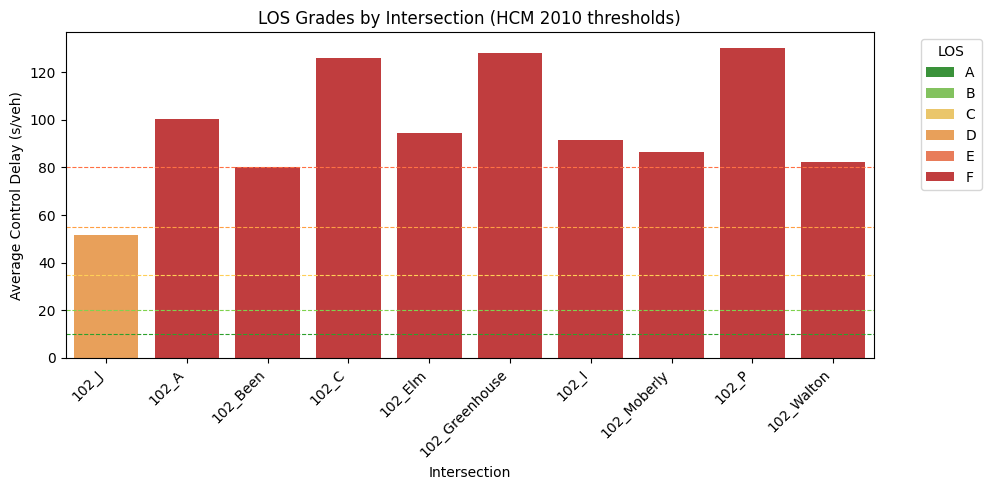

In [9]:
def plot_los_barchart(los_table: pd.DataFrame) -> None:
    """Render LOS grades per intersection using categorical ordering."""
    if los_table.empty:
        print("No LOS results available to plot.")
        return
    order = ["A", "B", "C", "D", "E", "F"]
    los_table = los_table.copy()
    los_table["LOS"] = pd.Categorical(los_table["LOS"], categories=order, ordered=True)
    los_table = los_table.sort_values(["LOS", "intersection_id"])

    palette = {
        "A": "#2ca02c",
        "B": "#7fd34e",
        "C": "#ffcf56",
        "D": "#ff9f43",
        "E": "#ff7043",
        "F": "#d62728",
    }
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=los_table,
        x="intersection_id",
        y="average_delay_s",
        hue="LOS",
        palette=palette,
        dodge=False,
    )
    plt.axhline(10, color="#2ca02c", linestyle="--", linewidth=0.8)
    plt.axhline(20, color="#7fd34e", linestyle="--", linewidth=0.8)
    plt.axhline(35, color="#ffcf56", linestyle="--", linewidth=0.8)
    plt.axhline(55, color="#ff9f43", linestyle="--", linewidth=0.8)
    plt.axhline(80, color="#ff7043", linestyle="--", linewidth=0.8)
    plt.ylabel("Average Control Delay (s/veh)")
    plt.xlabel("Intersection")
    plt.title("LOS Grades by Intersection (HCM 2010 thresholds)")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="LOS", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


plot_los_barchart(los_df.dropna(subset=["LOS"]))

## Next Steps and Interpretation Tips
- **Investigate LOS E–F** intersections first; these typically exceed 55 s/veh and indicate user discomfort.
- **Review warnings** collected in the LOS dictionaries for missing movements or zeroed lanes before trusting results.
- Adjust `DEFAULT_SATURATION_FLOW`, `plan_number`, or `aggregation` and rerun the computation cell to evaluate alternative scenarios (e.g., off-peak or actuated plans).